
# SNLI Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import spacy
from tqdm import tqdm
import ipywidgets as widgets
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
from gensim.models import FastText

import os, re, csv, math, codecs
import io


random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
data_dir = './hw2_data/'


### Tokenize dataset

In [ ]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in tqdm(dataset):

        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [91]:
snli_train = pd.read_csv(data_dir+'snli_train.tsv', sep="\t", index_col = False)
snli_val = pd.read_csv(data_dir+'snli_val.tsv', sep="\t", index_col=False)
label_names = snli_train.label.unique().tolist()
print('labels are:', label_names)

target_dic = {'neutral':1,'entailment':2, 'contradiction':0 }

train_sent1_tokens, _ = tokenize_dataset(snli_train.sentence1)
train_sent2_tokens, _ = tokenize_dataset(snli_train.sentence2)
train_target = [target_dic[i] for i in snli_train.label]

val_sent1_tokens, _ = tokenize_dataset(snli_val.sentence1)
val_sent2_tokens, _ = tokenize_dataset(snli_val.sentence2)
val_target = [target_dic[i] for i in snli_val.label]

In [2]:
train_sent1_tokens = pkl.load(open(data_dir+'train_sent1_tokens.p', 'rb'))
train_sent2_tokens = pkl.load(open(data_dir+'train_sent2_tokens.p', 'rb'))
train_target = pkl.load(open(data_dir+'train_target.p', 'rb'))
val_sent1_tokens = pkl.load(open(data_dir+'val_sent1_tokens.p', 'rb'))
val_sent2_tokens = pkl.load(open(data_dir+'val_sent2_tokens.p', 'rb'))
val_target = pkl.load(open(data_dir+'val_target.p', 'rb'))

99% sentence1 length in the training set is %.3f is 32
99% sentence2 length in the training set is %.3f is 18


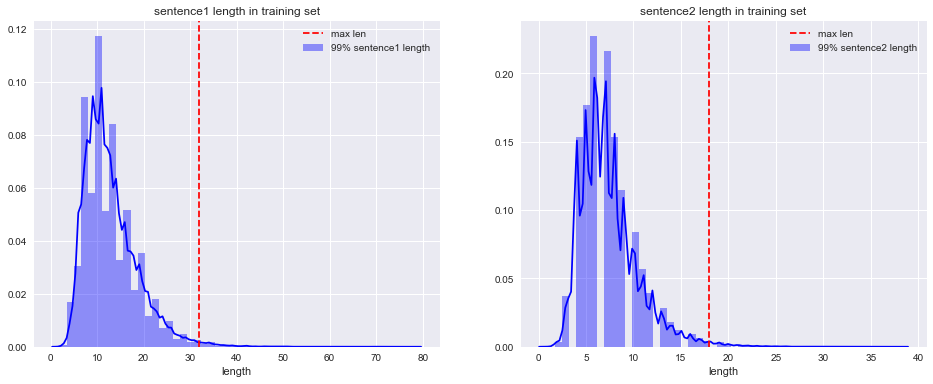

In [4]:
# set Maximum sentence length to 99% length in the training set, since it's reasonable to take the largest reasonable length we are likely to encounter
sentence_length1 = sorted([len(i) for i in train_sent1_tokens])
max_len1 = np.round(sentence_length1[int(len(sentence_length1) * .99)])
print('99% sentence1 length in the training set is %.3f is', max_len1)
sentence_length2 = sorted([len(i) for i in train_sent2_tokens])
max_len2 = np.round(sentence_length2[int(len(sentence_length2) * .99)])
print('99% sentence2 length in the training set is %.3f is', max_len2)

sns.set()
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.distplot(sentence_length1, hist=True, kde=True, color='b', label='99% sentence1 length')
plt.xlabel("length")
plt.axvline(x=max_len1, color='r', linestyle='--', label='max len')
plt.title('sentence1 length in training set'); plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(sentence_length2, hist=True, kde=True, color='b', label='99% sentence2 length')
plt.xlabel("length")
plt.axvline(x=max_len2, color='r', linestyle='--', label='max len')
plt.title('sentence2 length in training set'); plt.legend()
plt.savefig('figure/sentence_length.jpg')
plt.show()

In [5]:
MAX_SENTENCE1_LENGTH = 32
MAX_SENTENCE2_LENGTH = 18

### Pre-trained Word Embedding (fast-Text)

In [98]:
def load_vectors(fname):
    print('loading word embeddings...')
    embeddings_index = {}
    f = codecs.open(fname, encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

embeddings = load_vectors(data_dir+'wiki-news-300d-1M.vec')
pkl.dump(embeddings, open(data_dir+'embeddings.p', 'wb'))

In [3]:
embeddings = pkl.load(open(data_dir+'embeddings.p', 'rb'))
vocab = list(embeddings.keys())
print('found %s word vectors' % len(embeddings))

found 999995 word vectors


In [4]:
def build_vocab(embeddings, tokens_data,  max_vocab_size = len(embeddings.keys())):

    #if max_vocab_size:
    all_tokens = [i for tokens in tokens_data for i in tokens]
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    vocab = [i for i in vocab if i in embeddings.keys() ]
    vocab_len = len(vocab)
    print('length of vocabulary:',vocab_len) 

    id2token = list(vocab)                     
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    id2vector = np.zeros((len(id2token), 300))
    for i, word in enumerate(id2token):
        try:
            id2vector[i] = embeddings[word]
        except KeyError:
            id2vector[i] = np.random.normal(scale = 0.1, size = (300,))

    return id2token, token2id, id2vector

id2token, token2id, id2vector = build_vocab(embeddings, train_sent1_tokens+train_sent2_tokens)
vocab_size = len(id2token)


length of vocabulary: 18105


In [5]:
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tqdm(tokens_data):
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [6]:
train_sent1_indices = token2index_dataset(train_sent1_tokens, token2id)
train_sent2_indices = token2index_dataset(train_sent2_tokens, token2id)
val_sent1_indices = token2index_dataset(val_sent1_tokens, token2id)
val_sent2_indices  = token2index_dataset(val_sent2_tokens, token2id)

100%|██████████| 1000/1000 [00:00<00:00, 286046.78it/s]


### Data Loader

In [7]:
# MAX_SENTENCE_LENGTH is derived from 99% sentence length
MAX_SENTENCE1_LENGTH = 32
MAX_SENTENCE2_LENGTH = 18

class NLI_Dataset(Dataset):
    
    """
    Class that represents a train/validation dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1, data_list2, target_list):
        """
        @param data_list1: list of NLI tokens in premise
        @param data_list2: list of NLI tokens in hypothesis
        @param target_list: list of NLI targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """      
        token_idx1 = self.data_list1[key][:MAX_SENTENCE1_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE2_LENGTH]
        label = self.target_list[key]
        return [token_idx1, token_idx2, len(token_idx1),len(token_idx2), label]
    
def NLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), pad_width=((0,MAX_SENTENCE1_LENGTH-datum[2])), mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[1]), pad_width=((0,MAX_SENTENCE2_LENGTH-datum[3])), mode="constant", constant_values=0)
        data_list2.append(padded_vec2)

    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)), 
            torch.LongTensor(length_list1), torch.LongTensor(length_list2), 
            torch.LongTensor(label_list)]

In [8]:
BATCH_SIZE = 32
train_dataset = NLI_Dataset(train_sent1_indices, train_sent2_indices, train_target )
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=NLI_collate_func,
                                           shuffle=True)

val_dataset = NLI_Dataset(val_sent1_indices, val_sent2_indices,val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=NLI_collate_func,
                                           shuffle=True)

### Encoder

Define Recurrent Neural Net model

In [9]:
class RNN_Encoder(nn.Module):
    def __init__(self, hidden_size, fc_dim, dropout, dropout_fc, num_layers = 1, num_classes = 3, emb_size = 300):
        # RNN Accepts the following hyperparams:    
        # hidden_size: Hidden Size of layer in RNN for premise and hypothesis, [hidden_size1, hidden_size2]
        # fc_dim: Hidden Size of layer in fully connected layer
        # dropout: dropout rate for RNN
        # dropout_fc: dropout rate for fully connected layer
        # num_layers: number of layers in RNN
        # emb_size: Embedding Size
        
        super(RNN_Encoder, self).__init__()
        self.num_layers, self.dropout, self.emb_size, self.num_classes, self.fc_dim = num_layers, dropout, emb_size, num_classes, fc_dim
        self.hidden_size1, self.hidden_size2=  hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(id2vector)).float()
        self.rnn1 = nn.GRU(emb_size, self.hidden_size1, num_layers, self.dropout , batch_first=True, bidirectional = True)
        self.rnn2 = nn.GRU(emb_size, self.hidden_size2, num_layers, self.dropout, batch_first=True, bidirectional=True)
        self.fc_layer = nn.Sequential(nn.Linear(self.hidden_size1 + self.hidden_size2, self.fc_dim),
                                      nn.ReLU(inplace=True), 
                                      nn.Dropout(dropout_fc),
                                      nn.Linear(self.fc_dim, self.num_classes))

    def init_hidden(self, batch_size, hidden_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, hidden_size)
        return hidden

    def forward(self, x1, lengths1, x2, lengths2):
        
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        # reset hidden state
        self.hidden1 = self.init_hidden(batch_size1, self.hidden_size1)
        self.hidden2 = self.init_hidden(batch_size2, self.hidden_size2)

        # get embedding of characters
        embed1 = self.embedding(x1)   
        embed2 = self.embedding(x2)
        
        #sort by length
        sent_len1, idx_sort1 = np.sort(lengths1)[::-1], np.argsort(-lengths1)
        sent_len2, idx_sort2 = np.sort(lengths2)[::-1], np.argsort(-lengths2)
        embed1= torch.index_select(embed1, 0, idx_sort1)
        embed2= torch.index_select(embed2, 0, idx_sort2)
        
        # pack padded sequence
        embed_packed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, sent_len1, batch_first=True)
        embed_packed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, sent_len2, batch_first=True)

        # fprop though RNN
        _, self.hidden1 = self.rnn1(embed_packed1, self.hidden1)
        _, self.hidden2 = self.rnn2(embed_packed2, self.hidden2)
        
        # Un-sort by length
        idx_unsort1 = np.argsort(idx_sort1)
        idx_unsort2 = np.argsort(idx_sort2)
        
        self.hidden1 = torch.index_select(self.hidden1, 1, idx_unsort1)
        self.hidden2 = torch.index_select(self.hidden2, 1, idx_unsort2)

        # sum hidden activations of RNN across time
        hn1 = torch.sum(self.hidden1 , dim=0)
        hn2 = torch.sum(self.hidden2 , dim=0)
        
        #concatenate represententations 
        hidden_out = torch.cat((hn1, hn2), dim = 1)
        
        # feed into 2 fully-connected layers
        logits = self.fc_layer(hidden_out)

        return logits

In [10]:
# test
model = RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.2, dropout_fc = 0.1)
for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
    outputs = model(data1, lengths1, data2, lengths2)
    print(outputs.size())
    break

torch.Size([32, 3])


Define Convolutional Neural Net model 


In [11]:
class CNN_Encoder(nn.Module):
    def __init__(self, kernel_size, kernel_pad, hidden_size, fc_dim, dropout_fc,num_layers = 2, num_classes = 3, emb_size=300):
        # CNN Accepts the following hyperparams:    
        # kernel_size
        # kernel_pad
        # hidden_size: Hidden Size of layer in CNN for premise and hypothesis, [hidden_size1, hidden_size2]
        # fc_dim: Hidden Size of layer in fully connected layer
        # dropout_fc: dropout rate for fully connected layer
        # num_layers: number of layers in CNN
        # emb_size: Embedding Size
        
        super(CNN_Encoder, self).__init__()
        self.num_layers, self.emb_size, self.num_classes, self.fc_dim = num_layers,  emb_size, num_classes, fc_dim
        self.kernel_size, self.kernel_pad = kernel_size, kernel_pad
        self.hidden_size1, self.hidden_size2 =  hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(id2vector)).float()
        
        self.conv1_1 = nn.Conv1d(emb_size, self.hidden_size1, kernel_size = kernel_size , padding = kernel_pad )
        self.conv1_2 = nn.Conv1d(self.hidden_size1, self.hidden_size1, kernel_size = kernel_size, padding = kernel_pad )
        self.conv2_1 = nn.Conv1d(emb_size, self.hidden_size2, kernel_size = kernel_size, padding = kernel_pad )
        self.conv2_2 = nn.Conv1d(self.hidden_size2, self.hidden_size2, kernel_size = kernel_size, padding = kernel_pad )
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE1_LENGTH)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE2_LENGTH)
        
        self.fc_layer = nn.Sequential(nn.Linear(self.hidden_size1 + self.hidden_size2, self.fc_dim),
                                      nn.ReLU(inplace=True), 
                                      nn.Dropout(dropout_fc),
                                      nn.Linear(self.fc_dim, self.num_classes))


    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        # get embedding of characters
        embed1 = self.embedding(x1)  
        embed2 = self.embedding(x2)
                
        hidden1 = self.conv1_1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = self.conv1_2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = self.maxpool1(hidden1.transpose(1,2))
        
        hidden2 = self.conv2_1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))
        hidden2 = self.conv2_2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))   
        hidden2 = self.maxpool2(hidden2.transpose(1,2))
        
        #concatenate represententations 
        hidden_out = torch.cat((hidden1, hidden2), dim = 1)
 
        # sum hidden activationsacross time
        hidden_out = torch.sum(hidden_out, dim = 2)
        
        # feed into 2 fully-connected layers
        logits = self.fc_layer(hidden_out)

        return logits

In [12]:
# test
model = CNN_Encoder(kernel_size = 3, kernel_pad = 1 , hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
    outputs = model(data1, lengths1, data2, lengths2)
    print(outputs.size())
    break

torch.Size([32, 3])


### Training on SNLI

In [13]:
def test_model(loader, model):
   
    correct = 0
    total = 0
    result = []
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data_batch1, data_batch2, lengths_batch1, lengths_batch2, label_batch = data1, data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch1, lengths_batch1, data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        result.append([labels, predicted])
    return (100 * correct / total) , result  

In [14]:
def train_model(model, train_loader, val_loader, learning_rate, num_epochs, model_name, annealing_lr, model_del, print_):
    print(model_name)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of trainable parameters:%d'%pytorch_total_params)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    if annealing_lr:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

    train_loss = []
    train_acc = []
    val_acc = []
    result = []
    for epoch in range(num_epochs):
        if annealing_lr:
            scheduler.step()
        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, lengths1, data2, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss)
            
            # validate every 1000 iterations
            if i > 0 and i % 625 == 0:
                train_acc.append(test_model(train_loader, model)[0])
                val_accuracy, predicted = test_model(val_loader, model)
                result.append(predicted)
                val_acc.append(val_accuracy)
                if print_:
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_accuracy))          
    
    print("Val Accuracy:{0:.3f}%".format(test_model(val_loader, model)[0]))
    if model_del:
        del(model)
    else: 
        pkl.dump(model, open('models/'+str(model_name)+'.sav', 'wb'))
    return train_loss, train_acc, val_acc, result 

In [15]:
def plot_history(train_loss, train_acc, val_acc, model_name, num_epochs = 5): 
    x = np.arange(0 , num_epochs, 1/4).reshape(-1,1)
    sns.set()
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.title('Training Losses History of'+str(model_name)) 
    plt.xlabel('iterations')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, train_acc, label='Train Acc%')
    plt.plot(x, val_acc, label='Val Acc%')
    plt.title('Training/Validation Accuracies History of '+str(model_name)) 
    plt.xlabel("epochs")
    plt.ylabel("acc%")
    plt.ylim(45,95)
    plt.legend(loc='best')
    plt.savefig('figure/'+str(model_name)+'.jpg')
    plt.show()


### Hyperparameters Tuning

- RNN: hidden_size, fc_dim, dropout, dropout_fc, num_layers = 1, num_classes = 3, emb_size = 300
- CNN: kernel_size, kernel_pad, hidden_size, fc_dim, dropout_fc,num_layers = 2, num_classes = 3, emb_size=300
- train: learning_rate,  num_epochs, annealing_lr

In [16]:
#default parameter:
hidden_size = 100
fc_dim = 50
dropout = 0.1
dropout_fc = 0.1
kernel_size = 2
kernel_pad = 1
learning_rate = 3e-4
num_epochs = 5
annealing_lr = False

##### Model Parameters

In [17]:
models = {}
models['default_RNN'] =  RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
models['hidden_size_RNN'] = RNN_Encoder(hidden_size = [200, 200], fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
models['fc_dim_RNN'] = RNN_Encoder(hidden_size = [100, 100], fc_dim = 100, dropout = 0.1, dropout_fc = 0.1)
models['dropout_RNN'] = RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.3, dropout_fc = 0.3)
models['default_CNN'] = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
models['hidden_size_CNN'] = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [200, 200], fc_dim = 50, dropout_fc = 0.1)
models['kernal_CNN'] = CNN_Encoder(kernel_size = 5, kernel_pad = 2, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
models['fc_dim_CNN'] = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 100, dropout_fc = 0.1)
models['dropout_CNN'] = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.3)


default_RNN
number of trainable parameters:492603
Val Accuracy:66.300%


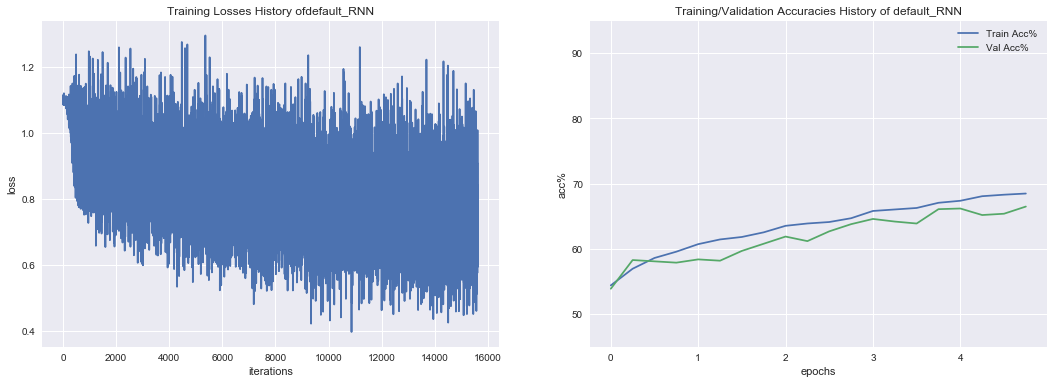

hidden_size_RNN
number of trainable parameters:1225003
Val Accuracy:66.100%


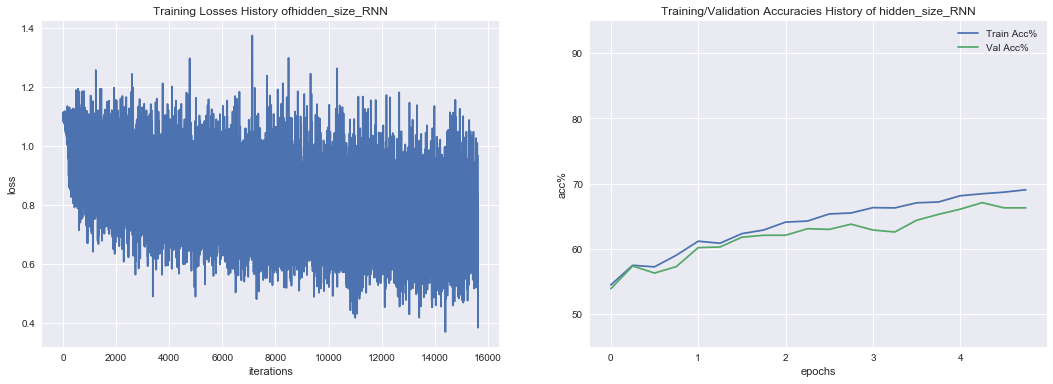

fc_dim_RNN
number of trainable parameters:502803
Val Accuracy:67.700%


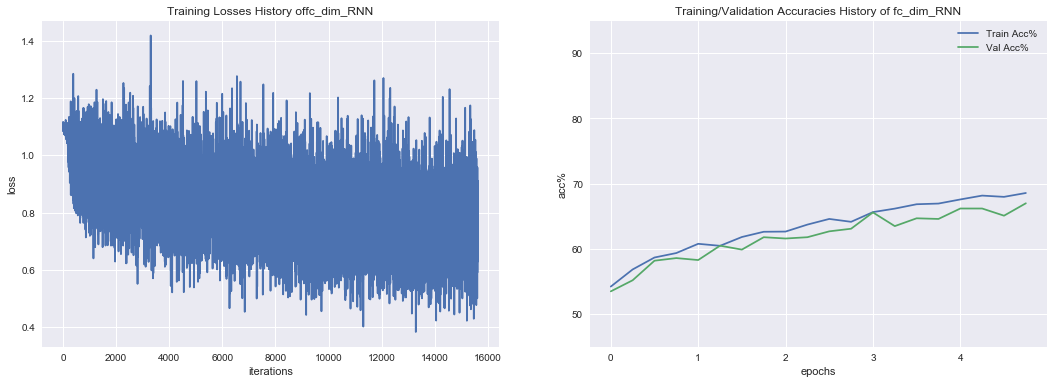

dropout_RNN
number of trainable parameters:492603
Val Accuracy:65.200%


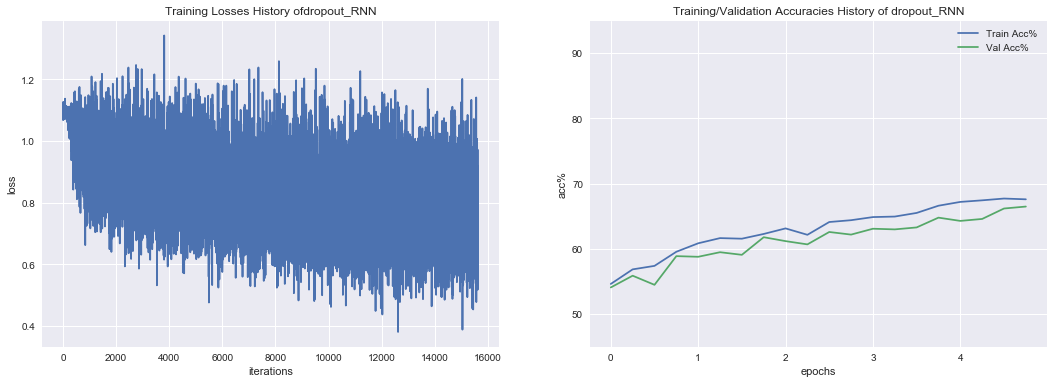

default_CNN
number of trainable parameters:250603
Val Accuracy:65.300%


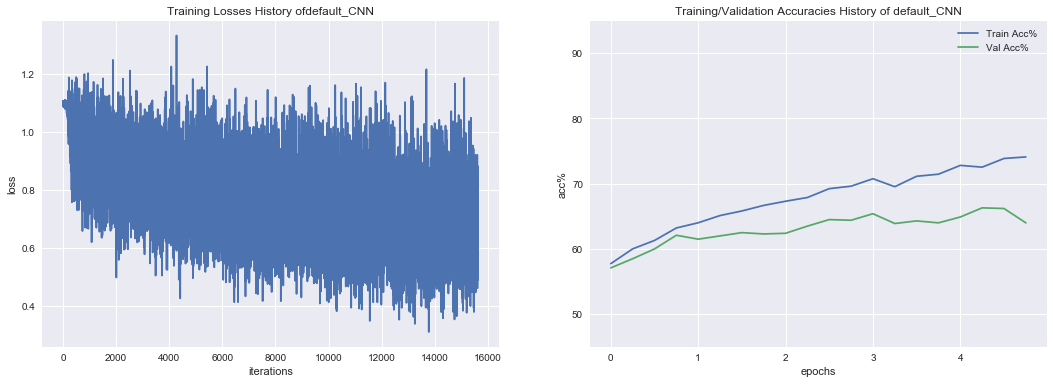

hidden_size_CNN
number of trainable parameters:621003
Val Accuracy:65.300%


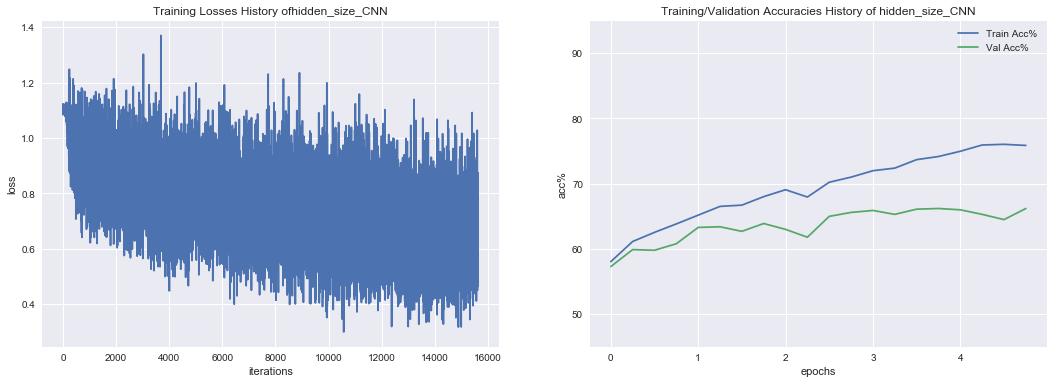

kernal_CNN
number of trainable parameters:410603
Val Accuracy:63.100%


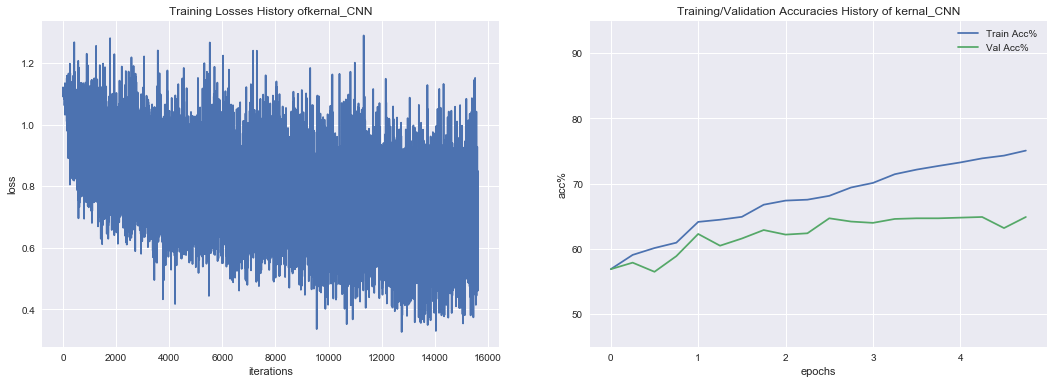

fc_dim_CNN
number of trainable parameters:260803
Val Accuracy:63.500%


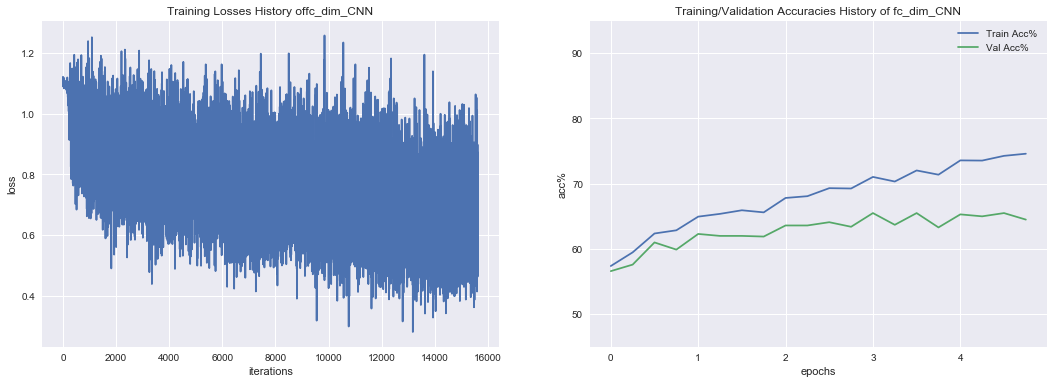

dropout_CNN
number of trainable parameters:250603
Val Accuracy:65.300%


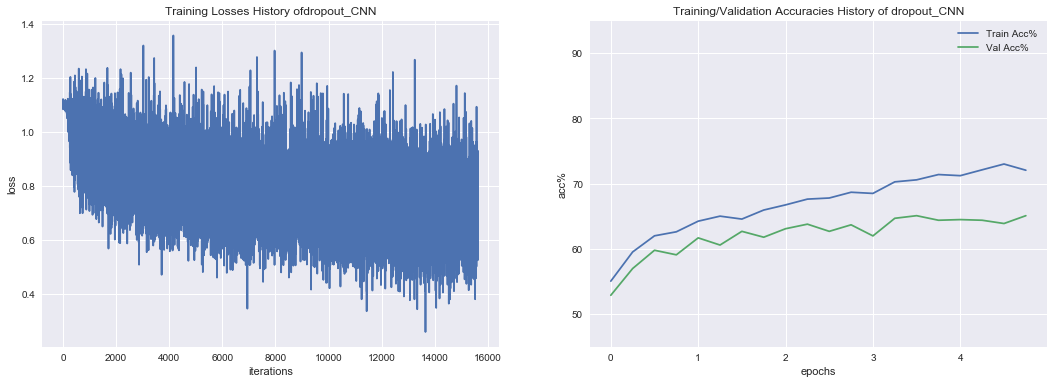

In [20]:
train_accuracy = {}
val_accuracy = {}
for model in models.keys():
    train_loss, train_acc, val_acc, _ = train_model(models[model], train_loader, val_loader, learning_rate, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
    train_accuracy[model] = train_acc
    val_accuracy[model] = val_acc
    plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)

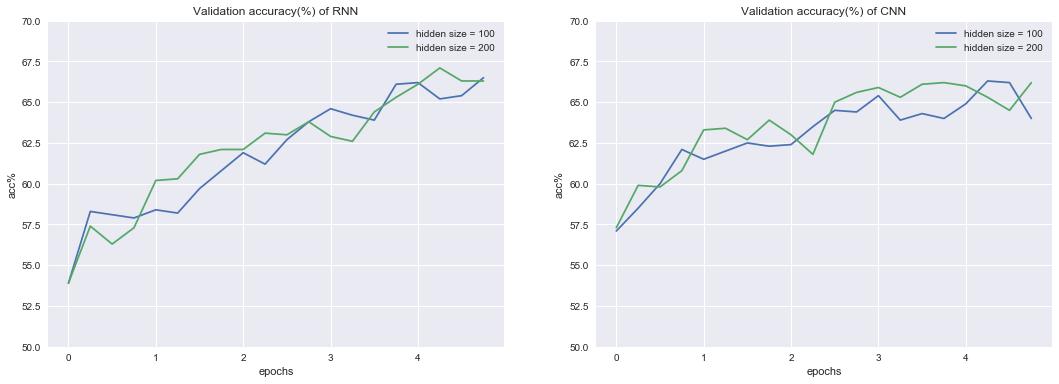

In [42]:
# hidden size
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(0 , 5, 1/4).reshape(-1,1)
sns.set()
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(x, val_accuracy['default_RNN'], label='hidden size = 100')
plt.plot(x, val_accuracy['hidden_size_RNN'], label='hidden size = 200')
plt.title('Validation accuracy(%) of RNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 70)
plt.legend(loc='best')
    
plt.subplot(1, 2, 2)
plt.plot(x, val_accuracy['default_CNN'],  label='hidden size = 100')
plt.plot(x, val_accuracy['hidden_size_CNN'], label='hidden size = 200')
plt.title('Validation accuracy(%) of CNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 70)
plt.legend(loc='best')
plt.savefig('figure/val_acc_hidden_size.jpg')
plt.show()

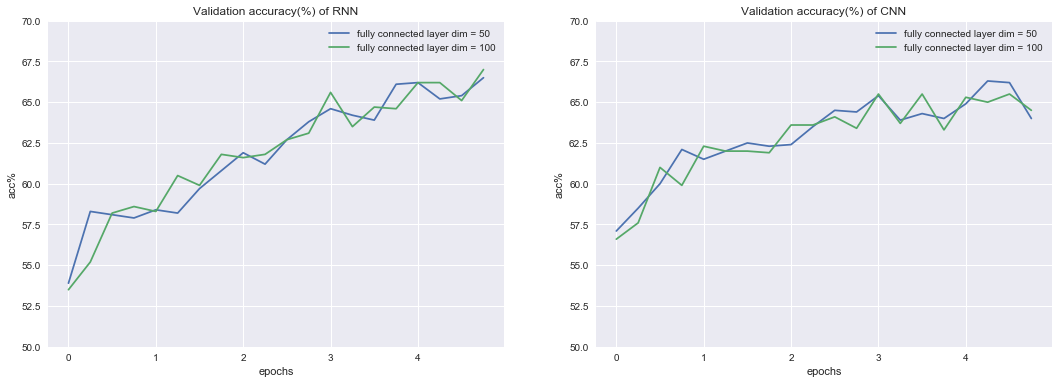

In [43]:
# fc_dim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(0 , 5, 1/4).reshape(-1,1)
sns.set()
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(x, val_accuracy['default_RNN'], label='fully connected layer dim = 50')
plt.plot(x, val_accuracy['fc_dim_RNN'], label= 'fully connected layer dim = 100')
plt.title('Validation accuracy(%) of RNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 70)
plt.legend(loc='best')
    
plt.subplot(1, 2, 2)
plt.plot(x, val_accuracy['default_CNN'], label='fully connected layer dim = 50')
plt.plot(x, val_accuracy['fc_dim_CNN'], label= 'fully connected layer dim = 100')
plt.title('Validation accuracy(%) of CNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.legend(loc='best')
plt.ylim(50, 70)
plt.savefig('figure/val_acc_fc_dim.jpg')
plt.show()

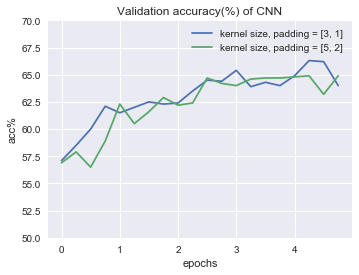

In [44]:
# Kernal size
x = np.arange(0 , 5, 1/4).reshape(-1,1)
sns.set()
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(x, val_accuracy['default_CNN'], label='kernel size, padding = [3, 1]')
plt.plot(x, val_accuracy['kernal_CNN'], label= 'kernel size, padding = [5, 2]')
plt.title('Validation accuracy(%) of CNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 70)
plt.legend(loc='best')
plt.savefig('figure/val_acc_kernel.jpg')
plt.show()

#### Training Parameters

##### Learning Rate

RNN_lr
number of trainable parameters:492603
Val Accuracy:69.000%


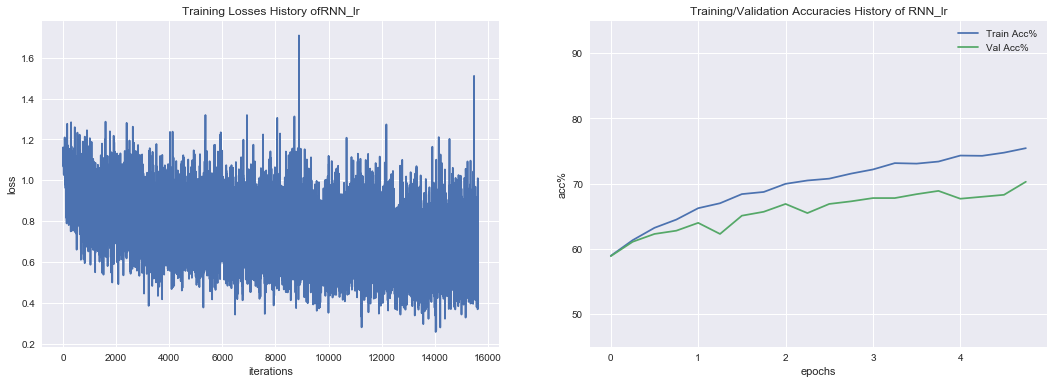

CNN_lr
number of trainable parameters:250603
Val Accuracy:64.900%


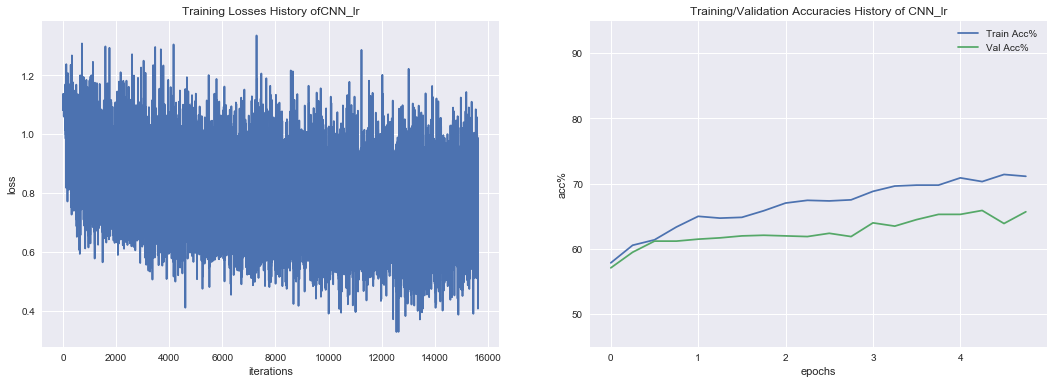

RNN_adj_lr
number of trainable parameters:492603
Val Accuracy:68.500%


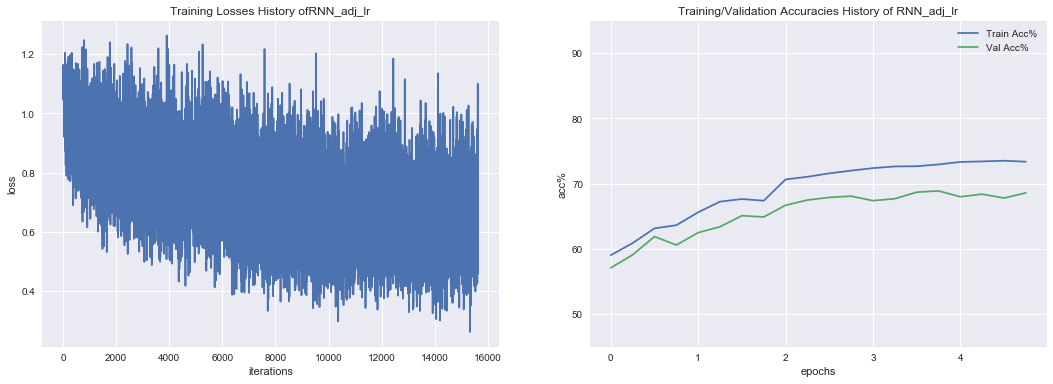

RNN_adj_lr2
number of trainable parameters:492603
Val Accuracy:61.600%


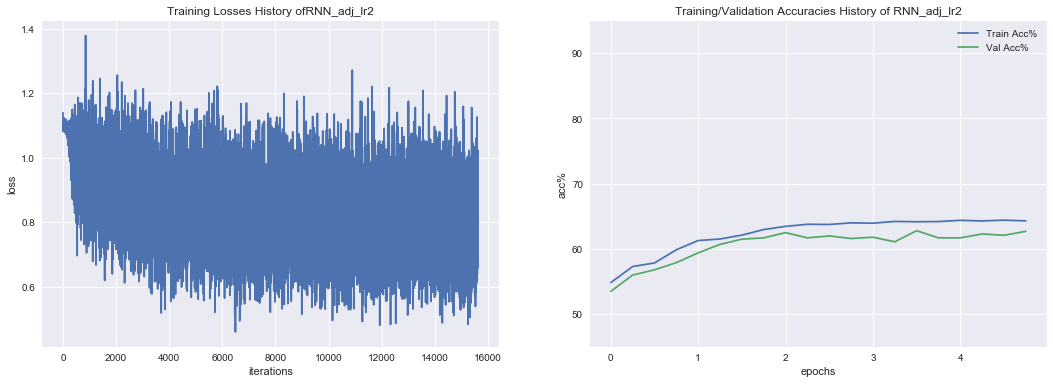

CNN_adj_lr
number of trainable parameters:250603
Val Accuracy:62.900%


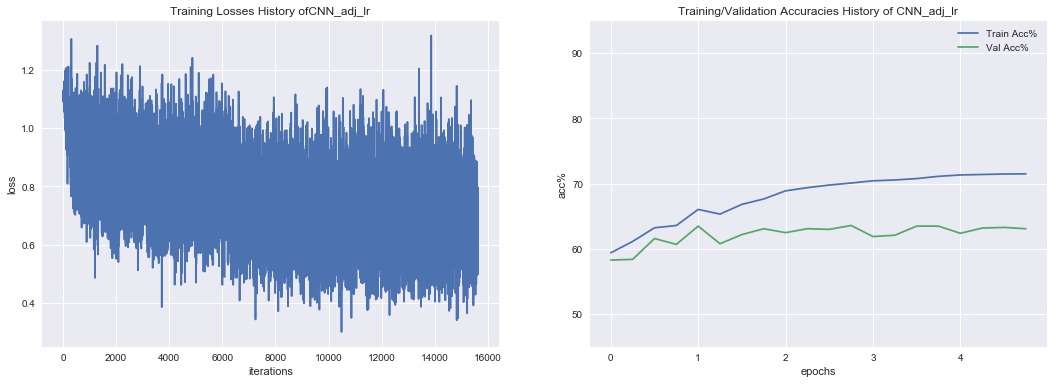

CNN_adj_lr2
number of trainable parameters:250603
Val Accuracy:64.000%


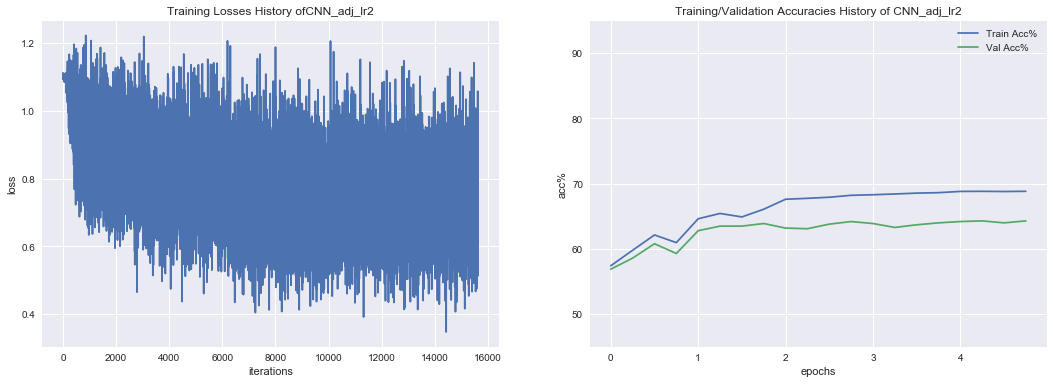

In [50]:
model = 'RNN_lr'
default_RNN = RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_RNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))

model = 'CNN_lr'
default_CNN = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_CNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))

model = 'RNN_adj_lr'
default_RNN = RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_RNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = True, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))

model = 'RNN_adj_lr2'
default_RNN = RNN_Encoder(hidden_size = [100, 100], fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_RNN, train_loader, val_loader, learning_rate = 3e-4, num_epochs = 5, model_name = model, annealing_lr = True, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))

model = 'CNN_adj_lr'
default_CNN = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_CNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = True, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))

model = 'CNN_adj_lr2'
default_CNN = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(default_CNN, train_loader, val_loader, learning_rate = 3e-4, num_epochs = 5, model_name = model, annealing_lr = True, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)
pkl.dump(train_accuracy, open('train_accuracy.p', 'wb'))
pkl.dump(val_accuracy, open('val_accuracy.p', 'wb'))


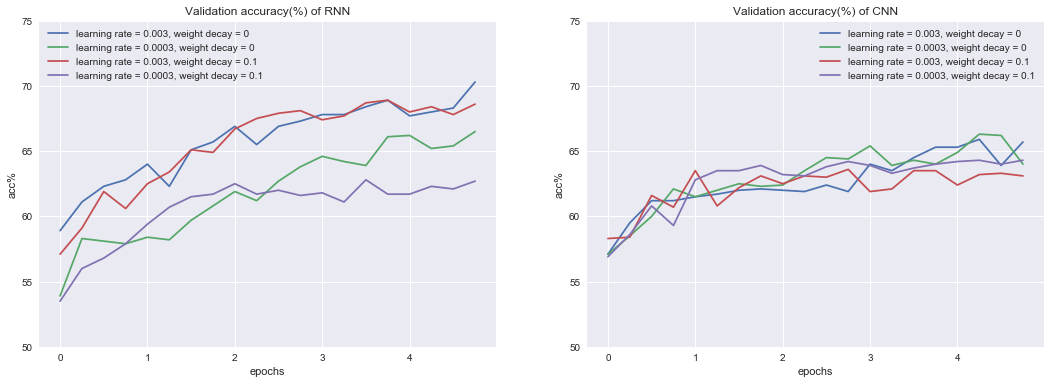

In [51]:
# Learning Rate & Weight Decay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(0 , 5, 1/4).reshape(-1,1)
sns.set()
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(x, val_accuracy['RNN_lr'], label= 'learning rate = 0.003, weight decay = 0')
plt.plot(x, val_accuracy['default_RNN'], label='learning rate = 0.0003, weight decay = 0')
plt.plot(x, val_accuracy['RNN_adj_lr'], label= 'learning rate = 0.003, weight decay = 0.1')
plt.plot(x, val_accuracy['RNN_adj_lr2'], label= 'learning rate = 0.0003, weight decay = 0.1')
plt.title('Validation accuracy(%) of RNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 75)
plt.legend(loc='best')
    
plt.subplot(1, 2, 2)
plt.plot(x, val_accuracy['CNN_lr'], label= 'learning rate = 0.003, weight decay = 0')
plt.plot(x, val_accuracy['default_CNN'], label='learning rate = 0.0003, weight decay = 0')
plt.plot(x, val_accuracy['CNN_adj_lr'], label= 'learning rate = 0.003, weight decay = 0.1')
plt.plot(x, val_accuracy['CNN_adj_lr2'], label= 'learning rate = 0.0003, weight decay = 0.1')
plt.title('Validation accuracy(%) of CNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 75)
plt.legend(loc='best')
plt.savefig('figure/val_acc_lr.jpg')
plt.show()

##### Interacting Method

In [18]:
# differnt methods for interacting the two encoded sentences(element-wise multiplication)
class RNN_Encoder_element_wise(nn.Module):
    def __init__(self, hidden_size, fc_dim, dropout, dropout_fc, num_layers = 1, num_classes = 3, emb_size = 300):
        # RNN Accepts the following hyperparams:    
        # hidden_size: Hidden Size of layer in RNN for premise and hypothesis, hidden_size1 = hidden_size2
        # fc_dim: Hidden Size of layer in fully connected layer
        # dropout: dropout rate for RNN
        # dropout_fc: dropout rate for fully connected layer
        # num_layers: number of layers in RNN
        # emb_size: Embedding Size
        
        super(RNN_Encoder_element_wise, self).__init__()
        self.num_layers, self.dropout, self.emb_size, self.num_classes, self.fc_dim = num_layers, dropout, emb_size, num_classes, fc_dim
        self.hidden_size=  hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(id2vector)).float()
        self.rnn1 = nn.GRU(emb_size, self.hidden_size, num_layers, self.dropout , batch_first=True, bidirectional = True)
        self.rnn2 = nn.GRU(emb_size, self.hidden_size, num_layers, self.dropout, batch_first=True, bidirectional=True)
        self.fc_layer = nn.Sequential(nn.Linear(self.hidden_size, self.fc_dim),
                                      nn.ReLU(inplace=True), 
                                      nn.Dropout(dropout_fc),
                                      nn.Linear(self.fc_dim, self.num_classes))

    def init_hidden(self, batch_size, hidden_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers * 2, batch_size, hidden_size)
        return hidden

    def forward(self, x1, lengths1, x2, lengths2):
        
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        # reset hidden state
        self.hidden1 = self.init_hidden(batch_size1, self.hidden_size)
        self.hidden2 = self.init_hidden(batch_size2, self.hidden_size)

        # get embedding of characters
        embed1 = self.embedding(x1)   
        embed2 = self.embedding(x2)
        
        #sort by length
        sent_len1, idx_sort1 = np.sort(lengths1)[::-1], np.argsort(-lengths1)
        sent_len2, idx_sort2 = np.sort(lengths2)[::-1], np.argsort(-lengths2)
        embed1= torch.index_select(embed1, 0, idx_sort1)
        embed2= torch.index_select(embed2, 0, idx_sort2)
        
        # pack padded sequence
        embed_packed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, sent_len1, batch_first=True)
        embed_packed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, sent_len2, batch_first=True)

        # fprop though RNN
        _, self.hidden1 = self.rnn1(embed_packed1, self.hidden1)
        _, self.hidden2 = self.rnn2(embed_packed2, self.hidden2)
        
        # Un-sort by length
        idx_unsort1 = np.argsort(idx_sort1)
        idx_unsort2 = np.argsort(idx_sort2)
        
        self.hidden1 = torch.index_select(self.hidden1, 1, idx_unsort1)
        self.hidden2 = torch.index_select(self.hidden2, 1, idx_unsort2)

        # sum hidden activations of RNN across time
        hn1 = torch.sum(self.hidden1 , dim=0)
        hn2 = torch.sum(self.hidden2 , dim=0)
        
        #concatenate represententations 
        hidden_out = hn1 * hn2
        
        # feed into 2 fully-connected layers
        logits = self.fc_layer(hidden_out)

        return logits

RNN_element_wise
number of trainable parameters:487603
Val Accuracy:69.700%


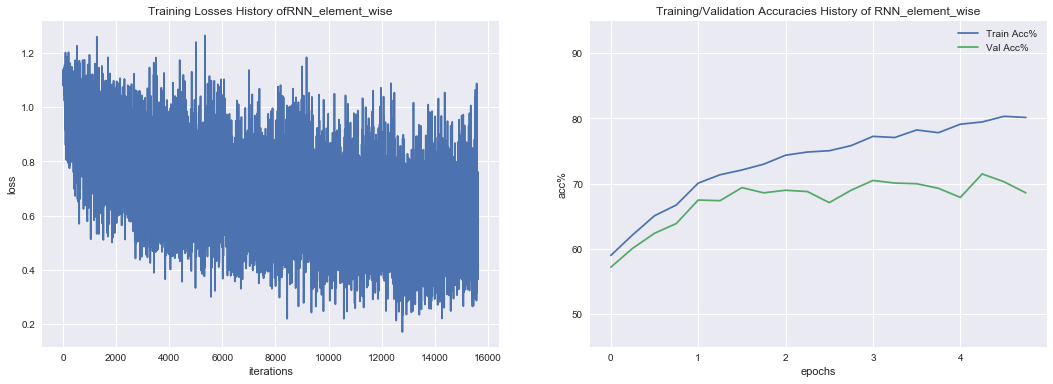

In [29]:
model = 'RNN_element_wise'
models_RNN_ew = RNN_Encoder_element_wise(hidden_size = 100, fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(models_RNN_ew, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)

In [19]:
class CNN_Encoder_element_wise(nn.Module):
    def __init__(self, kernel_size, kernel_pad, hidden_size, fc_dim, dropout_fc,num_layers = 2, num_classes = 3, emb_size=300):
        # CNN Accepts the following hyperparams:    
        # kernel_size
        # kernel_pad
        # hidden_size: Hidden Size of layer in CNN for premise and hypothesis, hidden_size1 = hidden_size2
        # fc_dim: Hidden Size of layer in fully connected layer
        # dropout_fc: dropout rate for fully connected layer
        # num_layers: number of layers in CNN
        # emb_size: Embedding Size
        
        super(CNN_Encoder_element_wise, self).__init__()
        self.num_layers, self.emb_size, self.num_classes, self.fc_dim = num_layers,  emb_size, num_classes, fc_dim
        self.kernel_size, self.kernel_pad = kernel_size, kernel_pad
        self.hidden_size =  hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(id2vector)).float()
        
        self.conv1_1 = nn.Conv1d(emb_size, self.hidden_size, kernel_size = kernel_size , padding = kernel_pad )
        self.conv1_2 = nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size = kernel_size, padding = kernel_pad )
        self.conv2_1 = nn.Conv1d(emb_size, self.hidden_size, kernel_size = kernel_size, padding = kernel_pad )
        self.conv2_2 = nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size = kernel_size, padding = kernel_pad )
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE1_LENGTH)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE2_LENGTH)
        
        self.fc_layer = nn.Sequential(nn.Linear(self.hidden_size, self.fc_dim),
                                      nn.ReLU(inplace=True), 
                                      nn.Dropout(dropout_fc),
                                      nn.Linear(self.fc_dim, self.num_classes))

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        # get embedding of characters
        embed1 = self.embedding(x1)  
        embed2 = self.embedding(x2)
                
        hidden1 = self.conv1_1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = self.conv1_2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden1 = self.maxpool1(hidden1.transpose(1,2))
        
        hidden2 = self.conv2_1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))
        hidden2 = self.conv2_2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))   
        hidden2 = self.maxpool2(hidden2.transpose(1,2))
        
        #concatenate represententations 
        hidden_out = hidden1 * hidden2
 
        # sum hidden activations across time
        hidden_out = torch.sum(hidden_out, dim = 2)
        
        # feed into 2 fully-connected layers
        logits = self.fc_layer(hidden_out)

        return logits

CNN_element_wise
number of trainable parameters:245603
Val Accuracy:64.400%


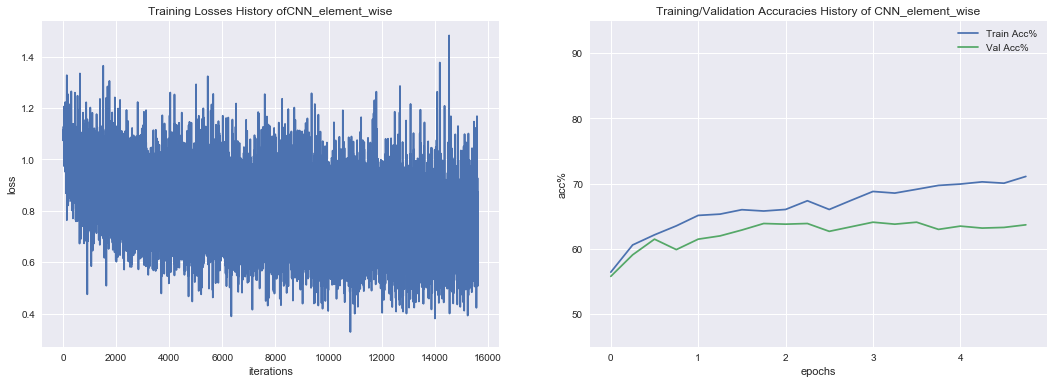

In [30]:
model = 'CNN_element_wise'
models_CNN_ew = CNN_Encoder_element_wise(kernel_size = 3, kernel_pad = 1, hidden_size = 100, fc_dim = 50, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(models_CNN_ew, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)

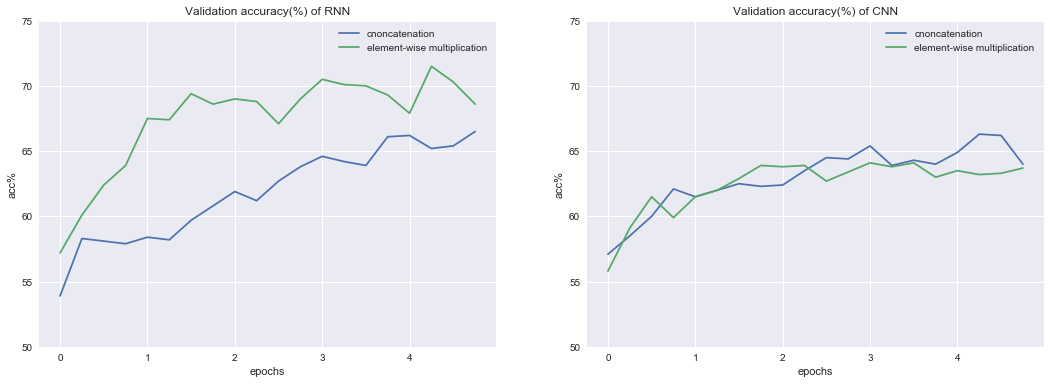

In [46]:
# Interacting Method
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(0 , 5, 1/4).reshape(-1,1)
sns.set()
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(x, val_accuracy['default_RNN'], label='cnoncatenation')
plt.plot(x, val_accuracy['RNN_element_wise'], label= 'element-wise multiplication')
plt.title('Validation accuracy(%) of RNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 75)
plt.legend(loc='best')
    
plt.subplot(1, 2, 2)
plt.plot(x, val_accuracy['default_CNN'], label='cnoncatenation')
plt.plot(x, val_accuracy['CNN_element_wise'], label= 'element-wise multiplication')
plt.title('Validation accuracy(%) of CNN') 
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50, 75)
plt.legend(loc='best')
plt.savefig('figure/val_acc_inter.jpg')
plt.show()

##### Best Model

best_RNN
number of trainable parameters:487603
Val Accuracy:71.900%


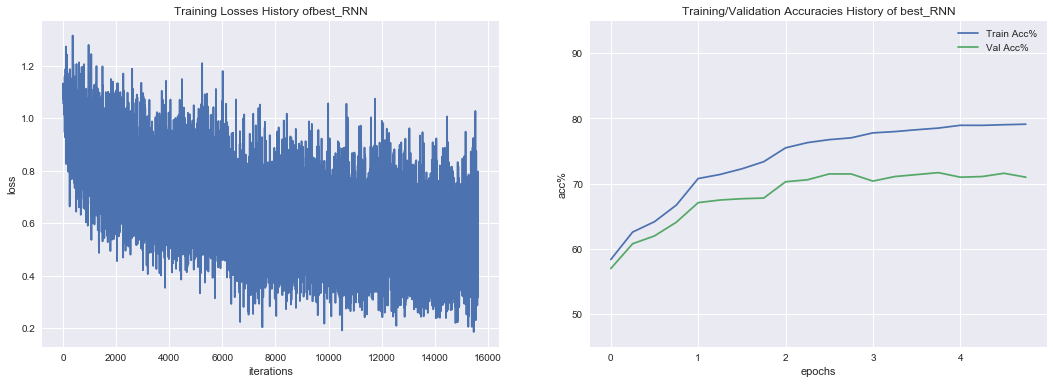

In [47]:
model = 'best_RNN'
best_RNN = RNN_Encoder_element_wise(hidden_size = 100, fc_dim = 50, dropout = 0.1, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(best_RNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = True, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)


best_CNN
number of trainable parameters:250603
Val Accuracy:64.100%


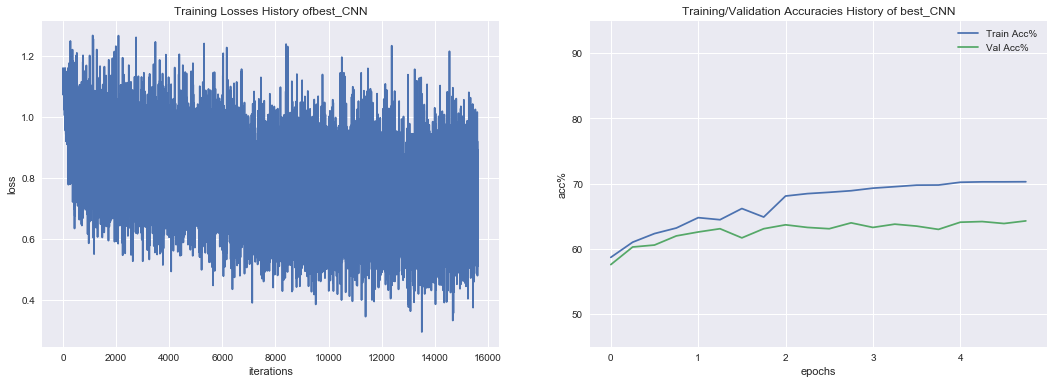

In [49]:
model = 'best_CNN'
best_CNN = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.1)
train_loss, train_acc, val_acc, _ = train_model(best_CNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)

In [ ]:
model = 'best_CNN'
best_CNN = CNN_Encoder(kernel_size = 3, kernel_pad = 1, hidden_size = [100, 100], fc_dim = 50, dropout_fc = 0.3)
train_loss, train_acc, val_acc, _ = train_model(best_CNN, train_loader, val_loader, learning_rate = 3e-3, num_epochs = 5, model_name = model, annealing_lr = False, model_del = False, print_ = False)
train_accuracy[model] = train_acc
val_accuracy[model] = val_acc
plot_history(train_loss, train_acc, val_acc, model_name = model, num_epochs = 5)

best_CNN
number of trainable parameters:250603


### Predictions

In [78]:
_, result = test_model(val_loader, best_RNN)
idx = []
for label, predicted in result:
    idx += (label.view_as(predicted).numpy() == predicted.numpy()).tolist()
    
correct_idx = [i for i, value in enumerate(idx) if value[0] == True]
incorrect_idx = [i for i, value in enumerate(idx) if value[0] != True]

##### 3 Correct Predictions

In [99]:
print('3 Correct Predictions:\n')
for i in np.random.choice(correct_idx, 3).tolist():
    print('Premise:%s\nHypothesis:%s\nLable:%s\n'%(snli_val.sentence1[i], snli_val.sentence2[i], snli_val.label[i]))

3 Correct Predictions:

Premise:A man talks on his cellphone in private .
Hypothesis:A man is talking to his wife on his cellphone .
Lable:neutral

Premise:A gentleman in a striped shirt gesturing with a stick-like object in his hand while passersby stare at him .
Hypothesis:A gentleman in a striped shirt not gesturing
Lable:contradiction

Premise:A woman in an orange shirt is enjoying food in a public setting .
Hypothesis:the lady in the orange shirt is eating
Lable:entailment



##### 3 Incorrect Predictions

In [100]:
print('3 Incorrect Predictions:\n')
for i in np.random.choice(incorrect_idx, 3).tolist():
    print('Premise:%s\nHypothesis:%s\nLable:%s\n'%(snli_val.sentence1[i], snli_val.sentence2[i], snli_val.label[i]))

3 Incorrect Predictions:

Premise:An Asian man is standing on a rusty dock surrounded by ropes and tires and is sticking a fishing pole into the water in front of him .
Hypothesis:A fisherman is working hard on the dock
Lable:neutral

Premise:A mountain biker rides up a hill on a red bicycle .
Hypothesis:The biker rode up the hill .
Lable:entailment

Premise:A woman sitting in a tan chair beside of a dog while smiling at the camera .
Hypothesis:The man is an actor at a photoshoot .
Lable:contradiction

